In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import kagglehub


path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'Training'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
validation_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'Training'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(path, 'Testing'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
checkpoint = ModelCheckpoint('best_model_brain_tumor.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.5712 - loss: 0.9821
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to best_model_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 116s 731ms/step - accuracy: 0.5721 - loss: 0.9803 - val_accuracy: 0.7143 - val_loss: 0.7620
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8263 - loss: 0.4777
Epoch 2: val_accuracy improved from 0.71429 to 0.74496, saving model to best_model_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 522ms/step - accuracy: 0.8264 - loss: 0.4774 - val_accuracy: 0.7450 - val_loss: 0.6871
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8569 - loss: 0.4039
Epoch 3: val_accuracy improved from 0.74496 to 0.76775, saving model to best_model_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 530ms/step - accuracy: 0.8569 - loss: 0.4038 - val_accuracy: 0.7677 - val_loss: 0.5721
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8783 - loss: 0.3453
Epoch 4: val_accuracy improved from 0.76775 to 0.79053, saving model to best_model_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 562ms/step - accuracy: 0.8783 - loss: 0.3453 - val_accuracy: 0.7905 - val_loss: 0.5610
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8673 - loss: 0.3578
Epoch 5: val_accuracy improved from 0.79053 to 0.79579, saving model to best_model_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 533ms/step - accuracy: 0.8674 - loss: 0.3577 - val_accuracy: 0.7958 - val_loss: 0.5272
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8754 - loss: 0.3243
Epoch 6: val_accuracy improved from 0.79579 to 0.80018, saving model to best_model_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 533ms/step - accuracy: 0.8755 - loss: 0.3242 - val_accuracy: 0.8002 - val_loss: 0.5177
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8963 - loss: 0.3033
Epoch 7: val_accuracy did not improve from 0.80018
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 523ms/step - accuracy: 0.8963 - loss: 0.3032 - val_accuracy: 0.7940 - val_loss: 0.5233
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9008 - loss: 0.2786
Epoch 8: val_accuracy improved from 0.80018 to 0.82296, saving model to best_model_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.9009 - loss: 0.2786 - val_accuracy: 0.8230 - val_loss: 0.4687
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8937 - loss: 0.2897
Epoch 9: val_accuracy did not improve from 0.82296
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 513ms/step - accuracy: 0.8937 - loss: 0.2896 - val_accuracy: 0.8098 - val_loss: 0.4731
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9095 - loss: 0.2543
Epoch 10: val_accuracy did not improve from 0.82296
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 583ms/step - accuracy: 0.9095 - loss: 0.2543 - val_accuracy: 0.8221 - val_loss: 0.4573
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9107 - loss: 0.2493
Epoch 11: val_accuracy improved from 0.82296 to 0.84312, saving model to best_model_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 530ms/step - accuracy: 0.9107 - loss: 0.2493 - val_accuracy: 0.8431 - val_loss: 0.4279
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9234 - loss: 0.2301
Epoch 12: val_accuracy did not improve from 0.84312
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 524ms/step - accuracy: 0.9234 - loss: 0.2302 - val_accuracy: 0.8396 - val_loss: 0.4349
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9126 - loss: 0.2315
Epoch 13: val_accuracy did not improve from 0.84312
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 527ms/step - accuracy: 0.9126 - loss: 0.2316 - val_accuracy: 0.8195 - val_loss: 0.4415
Epoch 14/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9168 - loss: 0.2224
Epoch 14: val_accuracy did not improve from 0.84312
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 564ms/step - accuracy: 0.9168 - loss: 0.2224 - val_accuracy: 0.8379 - val_loss: 0.4522
Epoch 15/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9124 - loss: 0.2354
Epoch 15

143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 513ms/step - accuracy: 0.9254 - loss: 0.2135 - val_accuracy: 0.8440 - val_loss: 0.4309
Epoch 17/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9256 - loss: 0.2136
Epoch 17: val_accuracy did not improve from 0.84400
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.9256 - loss: 0.2136 - val_accuracy: 0.8317 - val_loss: 0.4199
Epoch 18/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9213 - loss: 0.2110
Epoch 18: val_accuracy did not improve from 0.84400
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.9213 - loss: 0.2110 - val_accuracy: 0.8326 - val_loss: 0.4610
Epoch 19/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9281 - loss: 0.2048
Epoch 19: val_accuracy did not improve from 0.84400
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 512ms/step - accuracy: 0.9281 - loss: 0.2047 - val_accuracy: 0.8440 - val_loss: 0.4042
Epoch 20/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9147 - loss: 0.2300
Epoch 20

143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.9147 - loss: 0.2299 - val_accuracy: 0.8501 - val_loss: 0.4191


In [ ]:
model.load_weights('best_model_brain_tumor.h5')
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.2%}")
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.7920 - loss: 0.5277

Test Accuracy: 85.05%
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step



Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.83      0.87       300
  meningioma       0.83      0.59      0.69       306
     notumor       0.93      0.95      0.94       405
   pituitary       0.75      1.00      0.85       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.86      0.85      0.84      1311



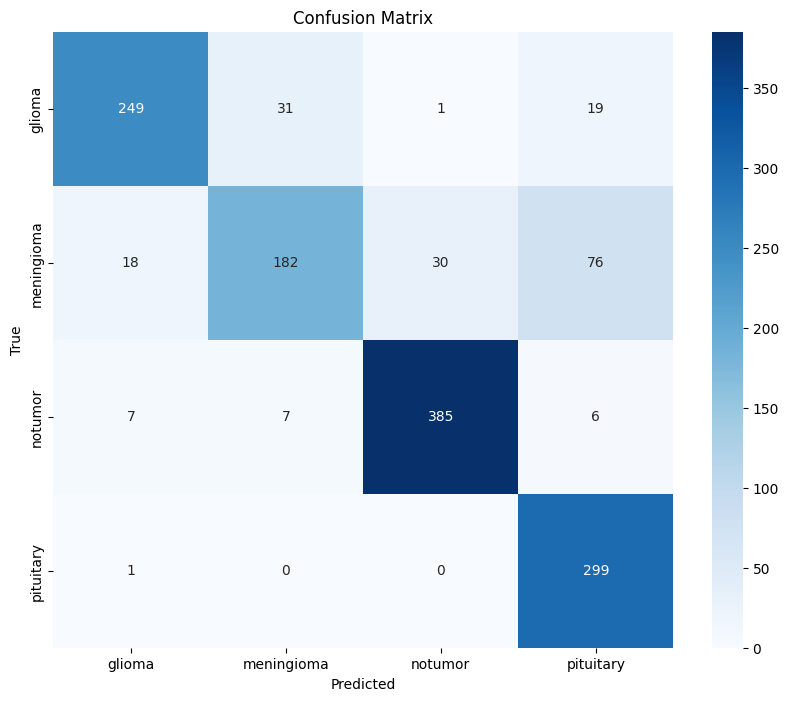

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()